In [1]:
import pandas as pd
import numpy as np
import re
import itertools as it
import os
import json

from plotting import create_df_for_forestplot, create_forestplot, save_pdf
from tables import create_supp_table


In [2]:
def get_most_deleterious_idx(ser):
    all_masks = set(ser.unique())
    most_del = "Missense_lenient"
    if "pLoF" in all_masks:
        most_del = "pLoF"
    elif "Missense_strict" in all_masks:
        most_del = "Missense_strict"
    most_del_idx = ser.loc[ser==most_del].index[0]
    return most_del_idx


In [3]:
# Obesity genes that were found in 
# 1. Rare variant burden association studies of BMI 
# 2. Must be in multiple cohorts 
# 3. Not sex specific or known ancestry specific 
# Note: Turcot genes are all driven by a single variant


akbari_genes = [
    "UHMK1", "GPR75", "ROBO1", "KIAA1109", "PCSK1", "GPR151", "SPARC", "UBR2", 
    "CALCR", "PDE3B", "ANO4", "KIAA0586", "MC4R", "DPP9", "ANKRD27", "GIPR"
]

akbari_plof_genes = [
    "GPR75", "ROBO1", "KIAA1109", "PCSK1", "UBR2", "PDE3B", "ANO4",
]

study_genes = set([
    "SLTM", "APBA1", "BLTP1", "PCSK1", "YLPM1", "MC4R", "BSN", "UBR2", "UBR3", "GIGYF1", "GRM7", "SLC5A3", "RIF1"
])

with open("../data/hgnc/hgnc_gene_map.json") as f:
    hgnc_dict = json.load(f)


In [4]:
meta_res_df = pd.read_csv("../data/meta/results/all_ancestry/ivw_fixed/meta_results.tsv.gz", sep="\t")
akbari_genes = [hgnc_dict[g] for g in akbari_plof_genes if hgnc_dict[g] not in study_genes]
known_genes_df = meta_res_df.loc[meta_res_df.gene.isin(akbari_genes)]
most_del_known_df = known_genes_df.loc[known_genes_df.groupby("gene")["gene_mask"].apply(get_most_deleterious_idx)].sort_values("beta").reset_index(drop=True)


# Plotting

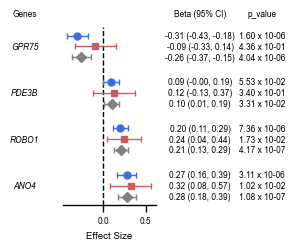

In [5]:
# Create forest plot
long_plot_df = create_df_for_forestplot(most_del_known_df)
fig = create_forestplot(
    long_plot_df, long_plot_df.gene.unique(), ["european", "non-european", "all"],
    labels_col="gene", categories_col="category", effect_sizes_col="beta", ci_low_col="ci_low", ci_high_col="ci_high",
    stats_cols=["Beta (95% CI)", "formatted_p_value"]
)

In [6]:
save_pdf("../data/known_genes/all_ancestry_forestplot.pdf", fig)

# Supplementary Table

In [7]:
anc_dir = f"../data/meta/processed/all_ancestry/"
supp_table = create_supp_table(most_del_known_df, anc_dir, include_samples=True)
supp_table.to_excel(f"../data/known_genes/monogenic_meta_known_genes.xlsx")
